# The Creation of the Distance Matrix for Patent IDs

In [4]:
import pandas as pd
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import nltk

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the main data sheet
file_path = 'Debris Data Full.xlsx'
main_df = pd.read_excel(file_path, sheet_name='Debris')

# Extract relevant columns
ipcr_columns = [col for col in main_df.columns if 'IPCR Class' in col]
display_key_column = 'Display Key'
text_columns = ['Title', 'Abstract', 'NPL Citations']

# Preprocessing using TreebankWordTokenizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

def preprocess(text):
    if pd.isna(text):
        return []
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Load pre-trained Word2Vec model
model = api.load('word2vec-google-news-300')

# Function to calculate cosine similarity between two patents' texts
def calculate_cosine_similarity(texts1, texts2):
    def get_average_vector(text):
        vectors = [model[word] for word in text if word in model]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(300)  # 300-dimensional zero vector as a fallback
    
    vector1 = get_average_vector(texts1)
    vector2 = get_average_vector(texts2)
    cosine_sim = cosine_similarity([vector1], [vector2])[0][0]
    normalized_cosine_sim = (cosine_sim + 1) / 2
    return normalized_cosine_sim

# Replace the text similarity calculation with the new cosine similarity-based approach
def calculate_text_similarity(patent1, patent2):
    combined_texts1 = []
    combined_texts2 = []
    
    for col in text_columns:
        combined_texts1.extend(preprocess(patent1[col]))
        combined_texts2.extend(preprocess(patent2[col]))
    
    return calculate_cosine_similarity(combined_texts1, combined_texts2) * 0.2

# Function to split IPCR code into components (same as before)
def split_ipcr(code):
    section = code[0]
    class_digits = code[1:3]
    subclass = code[3]
    group = code[4:code.index('/')]
    subgroup = code[code.index('/') + 1:]
    return section, class_digits, subclass, group, subgroup

# Calculate similarity between two IPCR codes (same as before)
def calculate_ipcr_similarity(code1, code2):
    section1, class_digits1, subclass1, group1, subgroup1 = split_ipcr(code1)
    section2, class_digits2, subclass2, group2, subgroup2 = split_ipcr(code2)

    def level_score(a, b):
        return 1 if a == b else 0
    
    def group_similarity(g1, g2):
        try:
            g1_int = int(g1)
            g2_int = int(g2)
            max_len = max(len(g1), len(g2))
            max_diff = abs(g1_int - g2_int)
            return max(0, 1 - max_diff / max_len)
        except ValueError:
            return 0

    def subgroup_similarity(sg1, sg2):
        if sg1 == sg2:
            return 1
        len1 = len(sg1)
        len2 = len(sg2)
        max_len = max(len1, len2)
        weight_per_digit = 0.30 / max_len
        matched_digits = 0
        for i in range(max_len):
            digit1 = sg1[i] if i < len1 else '0'
            digit2 = sg2[i] if i < len2 else '0'
            if digit1 == digit2:
                matched_digits += 1
            else:
                break
        similarity_score = weight_per_digit * matched_digits
        return similarity_score

    weights = {'section': 0.1, 'class': 0.15, 'subclass': 0.20, 'group': 0.25, 'subgroup': 0.30}

    section_score = level_score(section1, section2) * weights['section']
    class_score = level_score(class_digits1, class_digits2) * weights['class']
    subclass_score = level_score(subclass1, subclass2) * weights['subclass']
    group_score = group_similarity(group1, group2) * weights['group']
    subgroup_score = subgroup_similarity(subgroup1, subgroup2) * weights['subgroup']

    total_score = section_score + class_score + subclass_score + group_score + subgroup_score
    return total_score

# Calculate similarity between two patents based on their IPCR codes (same as before)
def calculate_patent_ipcr_similarity(patent1, patent2):
    ipcr_codes1 = [patent1[col] for col in ipcr_columns if pd.notna(patent1[col])]
    ipcr_codes2 = [patent2[col] for col in ipcr_columns if pd.notna(patent2[col])]
    
    if not ipcr_codes1 or not ipcr_codes2:
        return 0

    similarities = [calculate_ipcr_similarity(code1, code2) for code1 in ipcr_codes1 for code2 in ipcr_codes2]
    top_similarity = max(similarities) if similarities else 0
    
    return top_similarity * 0.8

# Calculate combined similarity between two patents
def combined_similarity(patent1, patent2):
    text_similarity = calculate_text_similarity(patent1, patent2)
    ipcr_similarity = calculate_patent_ipcr_similarity(patent1, patent2)
    final_similarity = text_similarity + ipcr_similarity
    return final_similarity

# Calculate the similarity matrix for all patents
display_keys = main_df[display_key_column].unique()
similarity_matrix_patent = pd.DataFrame(index=display_keys, columns=display_keys)

for i in range(len(display_keys)):
    for j in range(i, len(display_keys)):
        if i != j:
            patent1_data = main_df[main_df[display_key_column] == display_keys[i]]
            patent2_data = main_df[main_df[display_key_column] == display_keys[j]]
            
            if not patent1_data.empty and not patent2_data.empty:
                patent1 = patent1_data.iloc[0]
                patent2 = patent2_data.iloc[0]
                similarity = combined_similarity(patent1, patent2)
                similarity_matrix_patent.loc[display_keys[i], display_keys[j]] = similarity
                similarity_matrix_patent.loc[display_keys[j], display_keys[i]] = similarity

# Convert to numeric format and calculate the distance matrix
similarity_matrix_patent = similarity_matrix_patent.astype(float)
ipcr_distance_matrix_patent = 1 - similarity_matrix_patent

# Check for negative values in the matrices
negative_similarities = (similarity_matrix_patent < 0).sum().sum()
negative_distances = (ipcr_distance_matrix_patent < 0).sum().sum()

# Print the results of the check
print(f"Similarity Matrix Negative numbers : {negative_similarities}")
print(f"Distance Matrix Negative numbers : {negative_distances}")

# Save the distance matrix to an Excel file
ipcr_distance_matrix_patent.to_excel('debris_patent_name_distance_matrix.xlsx', index=True)

# Print the final results
print("Similarity Matrix (patent):")
print(similarity_matrix_patent)
print("Distance Matrix (patent):")
print(ipcr_distance_matrix_patent)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Similarity Matrix Negative numbers : 0
Distance Matrix Negative numbers : 8
Similarity Matrix (patent):
                    US 12033519 B2  WO 2024/137555 A1  US 12017803 B2  \
US 12033519 B2                 NaN           0.967633        0.967186   
WO 2024/137555 A1         0.967633                NaN        0.970066   
US 12017803 B2            0.967186           0.970066             NaN   
US 12017802 B2            0.959855           0.975633        0.979439   
WO 2024/126529 A1         0.977294           0.982149        0.978721   
...                            ...                ...             ...   
CN 115879211 A            0.259791           0.257485        0.535061   
US 2006/0090636 A1        0.403413           0.600583        0.360009   
JP H07186047 A            0.239057           0.274727        0.483340   
CN 1085177 A              0.751005           0.764411        0.770685   
NaN                            NaN                NaN             NaN   

                   

# This code calculates the average eps and min_samples of the dataset

Run 1: eps=0.86, min_samples=2, Silhouette Score=0.4034
Run 2: eps=0.89, min_samples=2, Silhouette Score=0.3498
Run 3: eps=0.99, min_samples=2, Silhouette Score=0.3747
Run 4: eps=0.62, min_samples=2, Silhouette Score=0.3549
Run 5: eps=0.60, min_samples=2, Silhouette Score=0.3712
Run 6: eps=0.84, min_samples=2, Silhouette Score=0.3799
Run 7: eps=0.62, min_samples=2, Silhouette Score=0.3549
Run 8: eps=0.87, min_samples=2, Silhouette Score=0.3662
Run 9: eps=0.83, min_samples=2, Silhouette Score=0.3799
Run 10: eps=0.83, min_samples=2, Silhouette Score=0.3789

Average eps: 0.79
Average min_samples: 2
Average Silhouette Score: 0.3714


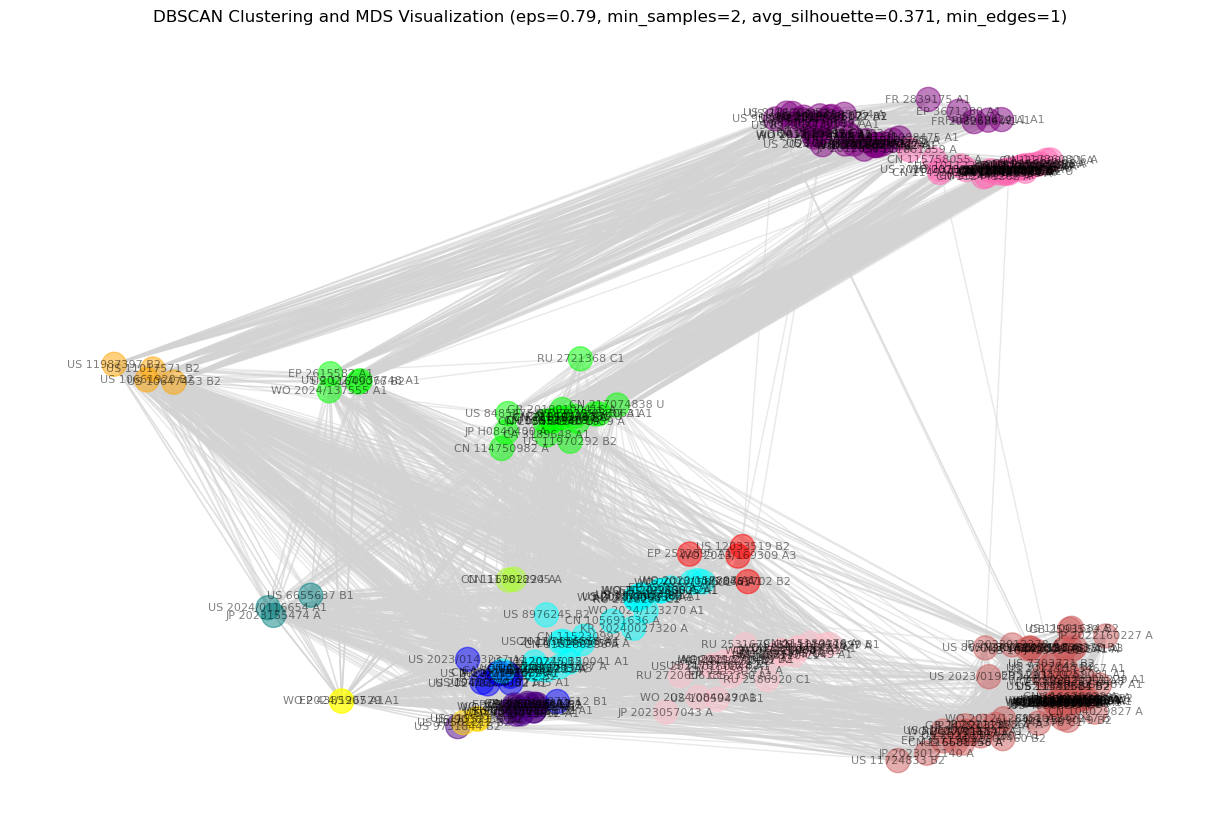

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Extract and prepare the original distance matrix data
original_data = distance_matrix_df.iloc[:, 1:].values  # Exclude the first column with Display Keys

# Handle missing values by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
original_data_imputed = imputer.fit_transform(original_data)

# Apply PCA to reduce dimensionality, retaining 90% of the variance
pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(original_data_imputed)

# Calculate pairwise Euclidean distances in the reduced space
from sklearn.metrics.pairwise import euclidean_distances
distance_matrix = euclidean_distances(reduced_data)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Define the Fitness Function
def fitness_function(eps, min_samples, distance_matrix, display_keys):
    dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(distance_matrix)
    
    if len(set(clusters)) <= 1:  # All points are noise or only one cluster
        return -1  # Invalid clustering
    
    score = silhouette_score(distance_matrix, clusters, metric='precomputed')
    return score

# Implement the MVO Algorithm (Simplified Example)
def mvo_optimization(distance_matrix, display_keys, num_universes=30, num_iterations=50, eps_range=(0.6, 1.0), min_samples_range=(2, 7)):
    universes = np.random.rand(num_universes, 2)
    universes[:, 0] = eps_range[0] + universes[:, 0] * (eps_range[1] - eps_range[0])
    universes[:, 1] = min_samples_range[0] + universes[:, 1] * (min_samples_range[1] - min_samples_range[0])
    
    best_fitness = -np.inf
    best_universe = None
    
    for iteration in range(num_iterations):
        for i in range(num_universes):
            eps = universes[i, 0]
            min_samples = int(universes[i, 1])
            fitness = fitness_function(eps, min_samples, distance_matrix, display_keys)
            
            if fitness > best_fitness:
                best_fitness = fitness
                best_universe = universes[i, :]
        
    return best_universe, best_fitness

# Run the optimization process 10 times
eps_values = []
min_samples_values = []
silhouette_scores = []

for i in range(10):
    best_params, best_fitness = mvo_optimization(distance_matrix, display_keys)
    best_eps, best_min_samples = best_params[0], int(best_params[1])
    
    eps_values.append(best_eps)
    min_samples_values.append(best_min_samples)
    silhouette_scores.append(best_fitness)
    
    print(f"Run {i+1}: eps={best_eps:.2f}, min_samples={best_min_samples}, Silhouette Score={best_fitness:.4f}")

# Calculate the averages
average_eps = np.mean(eps_values)
average_min_samples = int(np.round(np.mean(min_samples_values)))
average_silhouette = np.mean(silhouette_scores)

print(f"\nAverage eps: {average_eps:.2f}")
print(f"Average min_samples: {average_min_samples}")
print(f"Average Silhouette Score: {average_silhouette:.4f}")

# Run DBSCAN with the average parameters on the reduced data
dbscan = DBSCAN(metric='precomputed', eps=average_eps, min_samples=average_min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, omitting noise (label = -1)
for i, (x, y) in enumerate(reduced_coords):
    if clusters[i] != -1:  # Exclude noise points
        G.add_node(display_keys[i], pos=(x, y), cluster=clusters[i])

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 1,
    'Argentina': 1,
    'Australia': 1,
    'Austria': 1,
    'Belgium': 1,
    'Brazil': 1,
    'Bulgaria': 1,
    'Canada': 1,
    'Chile': 1,
    'China': 1,
    'Colombia': 1,
    'Costa Rica': 1,
    'Croatia': 1,
    'Cyprus': 1,
    'Czechia': 1,
    'Denmark': 1,
    'Ecuador': 1,
    'Egypt': 1,
    'European Patents': 1,
    'Finland': 1,
    'France': 1,
    'Georgia': 1,
    'Germany': 1,
    'Greece': 1,
    'Hong Kong': 1,
    'Hungary': 1,
    'India': 1,
    'Ireland': 1,
    'Israel': 1,
    'Italy': 1,
    'Japan': 1,
    'Jordan': 1,
    'Korea (the Republic of)': 1,
    'Latvia': 1,
    'Lithuania': 1,
    'Luxembourg': 1,
    'Malaysia': 1,
    'Mexico': 1,
    'Moldova (the Republic of)': 1,
    'Morocco': 1,
    'Netherlands': 1,
    'New Zealand': 1,
    'Norway': 1,
    'Peru': 1,
    'Philippines': 1,
    'Poland': 1,
    'Portugal': 1,
    'Romania': 1,
    'Russian Federation': 1,
    'Saudi Arabia': 1,
    'Serbia': 1,
    'Singapore': 1,
    'Slovakia': 1,
    'Slovenia': 1,
    'South Africa': 1,
    'Spain': 1,
    'Sweden': 1,
    'Switzerland': 1,
    'Taiwan (Province of China)': 1,
    'Tunisia': 1,
    'Turkey': 1,
    'Ukraine': 1,
    'United Kingdom of Great Britain and Northern Ireland': 1,
    'United States of America': 1,
    'World Intellectual Property Organisation': 1,
    'Zambia': 1
}

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 1

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define 15 colors for the clusters
vos_colors = [
    '#FF0000',  # Red
    '#00FF00',  # Green
    '#0000FF',  # Blue
    '#FFFF00',  # Yellow
    '#800080',  # Purple
    '#00FFFF',  # Cyan
    '#FFA500',  # Orange
    '#FFC0CB',  # Pink
    '#00FF00',  # Lime
    '#008080',  # Teal
    '#FFD700',  # Gold
    '#ADFF2F',  # Green Yellow
    '#FF69B4',  # Hot Pink
    '#CD5C5C',  # Indian Red
    '#4B0082'   # Indigo
]

# Assign colors to clusters
colors = []
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node].get('cluster', -1)
    if cluster != -1 and cluster < len(vos_colors):
        colors.append(vos_colors[cluster])
    else:
        colors.append('none')  # Omit nodes that are noise or do not meet min_samples

# Filter out nodes with color 'none'
final_filtered_nodes = [node for node, color in zip(final_filtered_graph.nodes(), colors) if color != 'none']
final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Get the unique cluster labels present in the final graph (excluding noise)
unique_clusters = sorted(set(nx.get_node_attributes(final_filtered_graph, 'cluster').values()) - {-1})

# Create a mapping from cluster label to VOSviewer color
cluster_to_color = {cluster: vos_colors[i % len(vos_colors)] for i, cluster in enumerate(unique_clusters)}

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
                font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)  # Set edge color to light gray
plt.title(f'DBSCAN Clustering and MDS Visualization (eps={average_eps:.2f}, min_samples={average_min_samples}, avg_silhouette={average_silhouette:.3f}, min_edges={degree_threshold})')
plt.show()

# This section generates the different netowrks based on specific filters (by country/region)

## All Patents

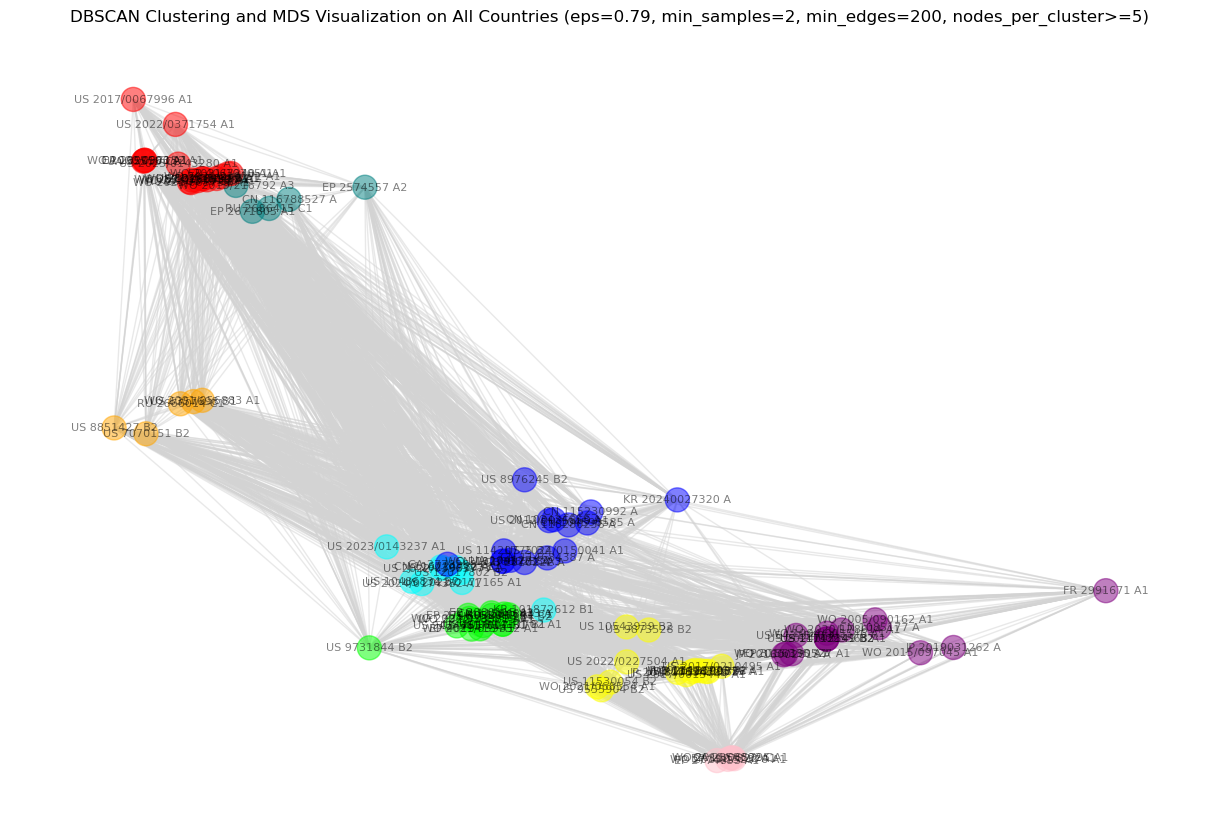

Cluster 39 (Yellow) Nodes: (14) Keywords: 053550, 10, 12, 16, 17, 18, 19, 20, 2000, 2001, 2002, 2006, 2008, 2010, 2011, 2015, 2019, 2019800434603, 2020, 2021, 21a, 22a, 30, 40, 50, action, adhesion, adjusting, aerospace, aiaa, al, allow, altitude, american, annual, antenna, apparatus, application, approximately, apr, artificial, attaching, attitude, aug, available, axis, battin, biddy, big, blocks, body, braking, ca, calibrating, capability, capable, capture, carrying, center, cgi, charging, chinese, circling, circulates, circulating, client, comprises, comprising, conference, configuration, configured, connected, connecting, connection, control, controller, corresponding, cusp, cycle, data, dated, debris, deliver, delivering, delivery, deorbit, deployable, deployment, device, different, direction, dissipation, drawing, earth, electromagnetic, elevated, em, enabling, end, energy, engineering, english, environment, equipment, et, european, executive, exit, extending, facilitate, facing,

In [33]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 1,
    'Argentina': 1,
    'Australia': 1,
    'Austria': 1,
    'Belgium': 1,
    'Brazil': 1,
    'Bulgaria': 1,
    'Canada': 1,
    'Chile': 1,
    'China': 1,
    'Colombia': 1,
    'Costa Rica': 1,
    'Croatia': 1,
    'Cyprus': 1,
    'Czechia': 1,
    'Denmark': 1,
    'Ecuador': 1,
    'Egypt': 1,
    'European Patents': 1,
    'Finland': 1,
    'France': 1,
    'Georgia': 1,
    'Germany': 1,
    'Greece': 1,
    'Hong Kong': 1,
    'Hungary': 1,
    'India': 1,
    'Ireland': 1,
    'Israel': 1,
    'Italy': 1,
    'Japan': 1,
    'Jordan': 1,
    'Korea (the Republic of)': 1,
    'Latvia': 1,
    'Lithuania': 1,
    'Luxembourg': 1,
    'Malaysia': 1,
    'Mexico': 1,
    'Moldova (the Republic of)': 1,
    'Morocco': 1,
    'Netherlands': 1,
    'New Zealand': 1,
    'Norway': 1,
    'Peru': 1,
    'Philippines': 1,
    'Poland': 1,
    'Portugal': 1,
    'Romania': 1,
    'Russian Federation': 1,
    'Saudi Arabia': 1,
    'Serbia': 1,
    'Singapore': 1,
    'Slovakia': 1,
    'Slovenia': 1,
    'South Africa': 1,
    'Spain': 1,
    'Sweden': 1,
    'Switzerland': 1,
    'Taiwan (Province of China)': 1,
    'Tunisia': 1,
    'Turkey': 1,
    'Ukraine': 1,
    'United Kingdom of Great Britain and Northern Ireland': 1,
    'United States of America': 1,
    'World Intellectual Property Organisation': 1,
    'Zambia': 1
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 200

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 5  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [34]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 39 Yellow, Nodes (14)

Shared Keywords
053550, 10, 12, 16, 17, 18, 19, 20, 2000, 2001, 2002, 2006, 2008, 2010, 2011, 2015, 2019, 2019800434603, 2020, 2021, 21a, 22a, 30, 40, 50, action, adhesion, adjusting, aerospace, aiaa, al, allow, altitude, american, annual, antenna, apparatus, application, approximately, apr, artificial, attaching, attitude, aug, available, axis, battin, biddy, big, blocks, body, braking, ca, calibrating, capability, capable, capture, carrying, center, cgi, charging, chinese, circling, circulates, circulating, client, comprises, comprising, conference, configuration, configured, connected, connecting, connection, control, controller, corresponding, cusp, cycle, data, dated, debris, deliver, delivering, delivery, deorbit, deployable, deployment, device, different, direction, dissipation, drawing, earth, electromagnetic, elevated, em, enabling, end, energy, engineering, english, environment, equipment, et, european, executive, exit, extending, facilitate, fa

##  China

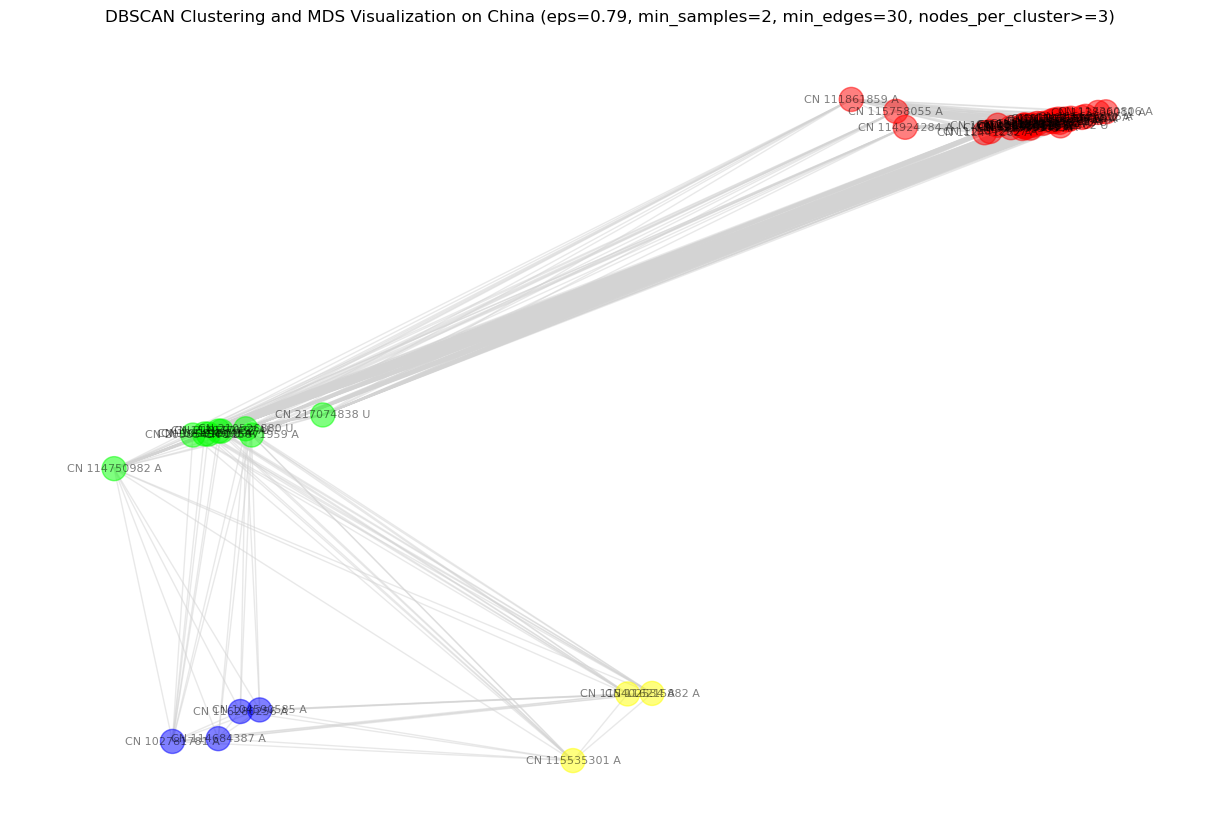

Cluster 12 (Red) Nodes: (32) Keywords: 04, 06, 10, 1016, 16, 2015, 2016, 2020, 28, abandoned, accelerated, according, accurate, accurately, achieved, acting, action, active, adaptation, adaptive, adjustable, adjusting, adjustment, adopt, adopts, advantages, aerostat, aiming, aircraft, aluminum, anchor, angle, angles, annular, application, applied, applying, arm, arms, arranged, array, arresting, art, assembled, assembly, association, atmosphere, atmospheric, attachment, attitude, automatic, automatically, autonomous, auxiliary, avoiding, bag, bands, barb, barbs, base, based, basket, beam, bearing, belongs, belt, beneficial, bent, bin, bionic, block, blocking, blocks, board, body, box, buffer, buffering, burning, burnt, cabin, calculating, capable, capture, captured, captures, capturing, carried, carrier, carrying, catching, cavity, cellular, center, chamber, circulating, circumferential, clamp, clamping, claw, cleaner, cleaning, collected, collection, collector, collision, column, comb

In [37]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 1,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 30

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 3  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [38]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 12 Red, Nodes (32)

Shared Keywords
04, 06, 10, 1016, 16, 2015, 2016, 2020, 28, abandoned, accelerated, according, accurate, accurately, achieved, acting, action, active, adaptation, adaptive, adjustable, adjusting, adjustment, adopt, adopts, advantages, aerostat, aiming, aircraft, aluminum, anchor, angle, angles, annular, application, applied, applying, arm, arms, arranged, array, arresting, art, assembled, assembly, association, atmosphere, atmospheric, attachment, attitude, automatic, automatically, autonomous, auxiliary, avoiding, bag, bands, barb, barbs, base, based, basket, beam, bearing, belongs, belt, beneficial, bent, bin, bionic, block, blocking, blocks, board, body, box, buffer, buffering, burning, burnt, cabin, calculating, capable, capture, captured, captures, capturing, carried, carrier, carrying, catching, cavity, cellular, center, chamber, circulating, circumferential, clamp, clamping, claw, cleaner, cleaning, collected, collection, collector, collision, column,

# United States

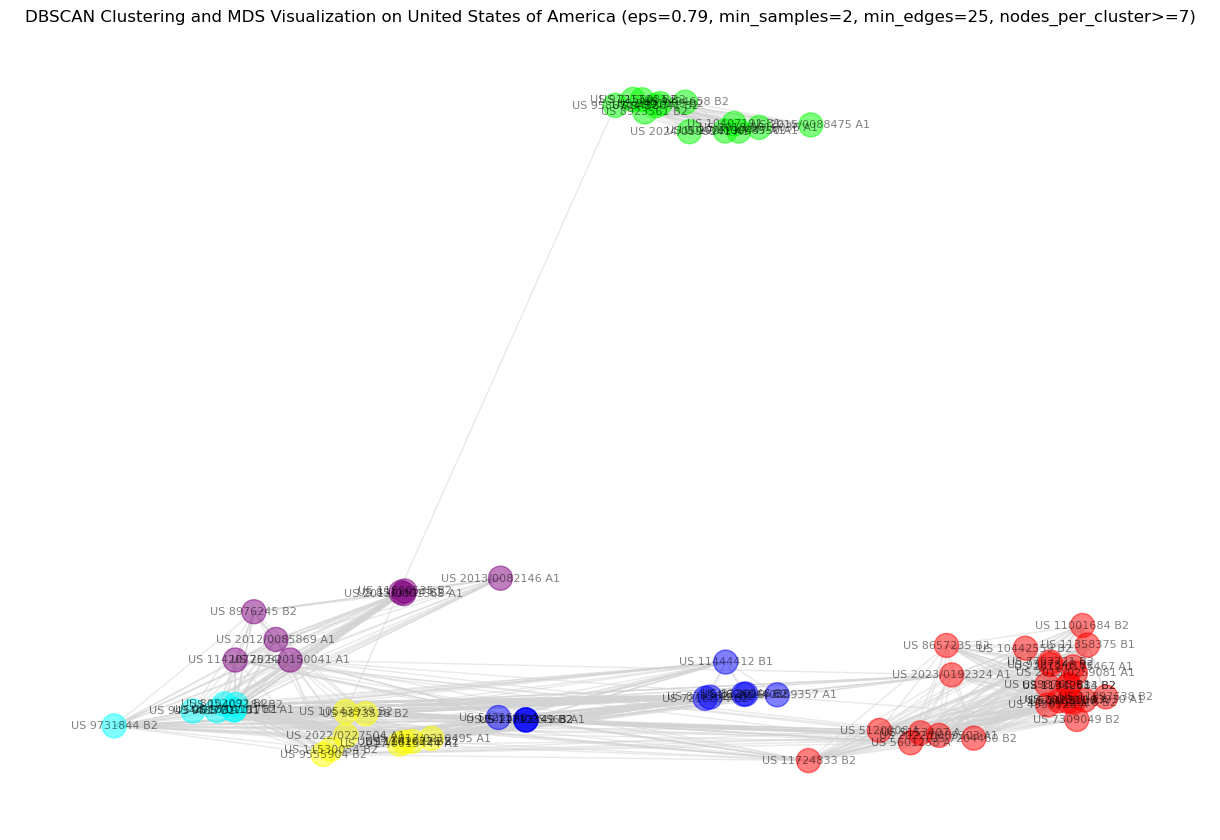

Cluster 4 (Lime) Nodes: (13) Keywords: 0003, 001, 0273, 04, 073872, 073940, 10, 1016, 11, 1117, 1177, 12, 13, 14, 15, 16, 18, 1991, 2002, 2008, 2009, 2010, 2011, 2013, 2016, 2018, 2019, 21, 25, 29, 41, abstract, accordance, according, accurately, adapted, advanced, advances, agent, aiaa, al, algorithm, analysis, angular, appearance, application, applications, applying, apr, artificial, associated, asteroids, astronomical, aug, automatic, available, average, axes, axis, barycenter, based, boundary, breakup, calculates, calculating, candidate, captured, celestial, central, characterization, code, collision, com, combination, comprising, computing, conference, configured, convex, corresponding, coupled, created, criterion, current, curve, cut, data, dated, debris, decision, der, deriving, described, detect, detecting, detection, determined, determining, discrete, distance, distinguish, distribution, dlr, doi, domain, downloaded, earth, eliminated, embodiment, emits, employed, english, env

In [54]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 1,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 25

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 7  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [55]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 4 Lime, Nodes (13)

Shared Keywords
0003, 001, 0273, 04, 073872, 073940, 10, 1016, 11, 1117, 1177, 12, 13, 14, 15, 16, 18, 1991, 2002, 2008, 2009, 2010, 2011, 2013, 2016, 2018, 2019, 21, 25, 29, 41, abstract, accordance, according, accurately, adapted, advanced, advances, agent, aiaa, al, algorithm, analysis, angular, appearance, application, applications, applying, apr, artificial, associated, asteroids, astronomical, aug, automatic, available, average, axes, axis, barycenter, based, boundary, breakup, calculates, calculating, candidate, captured, celestial, central, characterization, code, collision, com, combination, comprising, computing, conference, configured, convex, corresponding, coupled, created, criterion, current, curve, cut, data, dated, debris, decision, der, deriving, described, detect, detecting, detection, determined, determining, discrete, distance, distinguish, distribution, dlr, doi, domain, downloaded, earth, eliminated, embodiment, emits, employed, english

# Japan

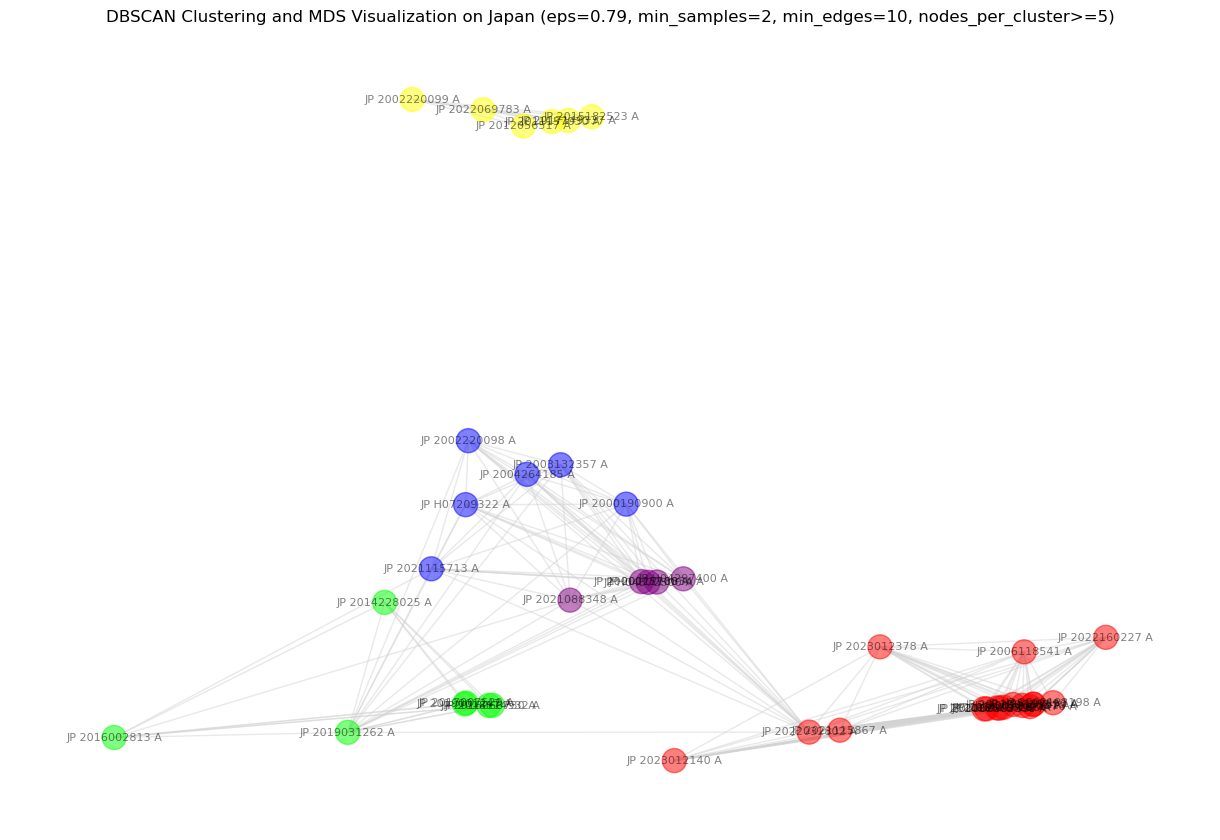

Cluster 17 (Purple) Nodes: (5) Keywords: 101, 1a, 200, airframe, altitude, arranged, artificial, based, beam, camera, capable, ccd, changing, collision, computer, constitution, data, debris, degree, detected, detecting, detector, device, different, direction, display, earth, exterior, filter, flight, geostationary, grasp, image, irradiated, laser, light, meteoroid, method, moving, navigator, object, observation, observing, optical, orbit, orbital, photographing, plurality, position, possible, problem, propulsion, provide, purpose, range, satellite, sensing, sensors, solution, solved, space, spacecraft, speed, station, structure, sun, sunlight, time, trace, wall
Display Keys in Cluster 17: JP 2000025700 A, JP H04372500 A, JP H04297400 A, JP 2021088348 A, JP 2011218834 A
Cluster 13 (Red) Nodes: (17) Keywords: 10, 101, 102, 12, 1a, 1b, 2006, 201, 2011, 202, 210, 290, 291, 293, 294, 401, 500, 5e, activities, adjust, air, alloy, altitude, aluminum, annular, applied, approaching, arranged, a

In [42]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 1,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 10

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 5  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [43]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 17 Purple, Nodes (5)

Shared Keywords
101, 1a, 200, airframe, altitude, arranged, artificial, based, beam, camera, capable, ccd, changing, collision, computer, constitution, data, debris, degree, detected, detecting, detector, device, different, direction, display, earth, exterior, filter, flight, geostationary, grasp, image, irradiated, laser, light, meteoroid, method, moving, navigator, object, observation, observing, optical, orbit, orbital, photographing, plurality, position, possible, problem, propulsion, provide, purpose, range, satellite, sensing, sensors, solution, solved, space, spacecraft, speed, station, structure, sun, sunlight, time, trace, wall

Display Keys /w description
JP 2000025700 A - PROBLEM TO BE SOLVED: To provide a method and a device which uses an optical detector, performs observation of one or a plurality of debris, determines moving speed and moving direction of the debris based on trace of debris' movement recorded in an image provided from the dete

# France

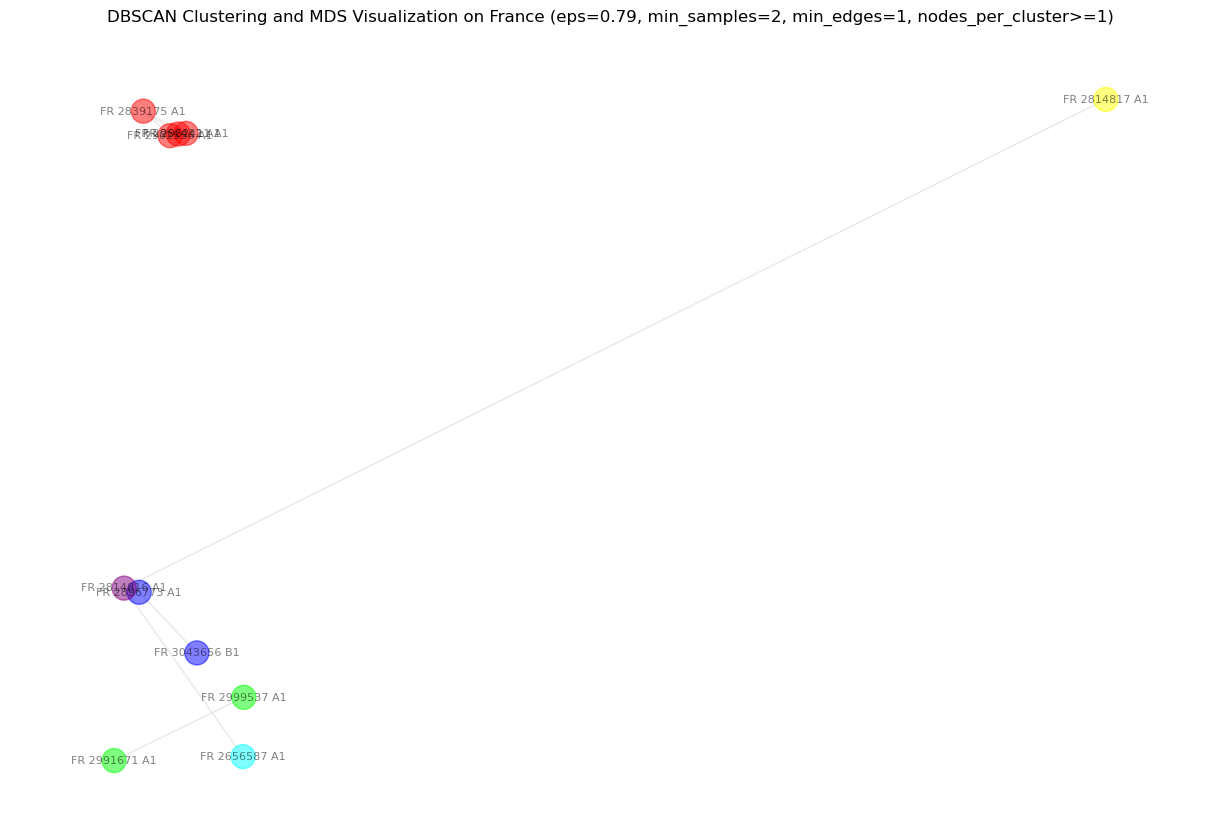

Cluster 15 (Lime) Nodes: (2) Keywords: 01, 05, 0633, 10, 12, 17, 1997, 2000, 2011, al, archive, au, bris, capture, ce, com, couplage, dans, debris, des, dispositif, du, dã, en, espace, et, fixã, grasp, harpon, hicule, http, internet, issn, la, le, moins, moyens, mã, notamment, objet, orbite, org, organe, ou, pages, ploiement, ployable, poche, pour, procede, retrieved, space, spatial, tethers, une, url, vol, vue, vã, web, www
Display Keys in Cluster 15: FR 2991671 A1, FR 2999537 A1
Cluster 70 (Yellow) Nodes: (1) Keywords: 
Display Keys in Cluster 70: FR 2814817 A1
Cluster 17 (Blue) Nodes: (2) Keywords: 04, 06, 18, 20, 2004, 2005, april, au, automatically, bris, conference, control, darmstadt, debris, des, discharge, dã, electrical, end, european, extinction, fluid, fourth, fusã, germany, june, orbit, passivation, procedure, proceedings, propulseur, propulsion, satellites, sonde, space, spacecraft, spatiaux, stage, une
Display Keys in Cluster 17: FR 3043656 B1, FR 2896773 A1
Cluster 4 (R

In [44]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 1,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 1

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 1  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [45]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 15 Lime, Nodes (2)

Shared Keywords
01, 05, 0633, 10, 12, 17, 1997, 2000, 2011, al, archive, au, bris, capture, ce, com, couplage, dans, debris, des, dispositif, du, dã, en, espace, et, fixã, grasp, harpon, hicule, http, internet, issn, la, le, moins, moyens, mã, notamment, objet, orbite, org, organe, ou, pages, ploiement, ployable, poche, pour, procede, retrieved, space, spatial, tethers, une, url, vol, vue, vã, web, www

Display Keys /w description
FR 2991671 A1 - ProcÃ©dÃ© et dispositif de capture et de couplage en vue de la dÃ©sorbitation ou de la rÃ©orbitation d'au moins un objet (32) dans l'espace, au moyen d'un voile ou d'une poche (14) souple et dÃ©ployable de capture de l'objet, de moyens (18) de dÃ©ploiement de la poche par gonflage d'un organe (24) s'Ã©tendant sur au moins une partie du bord de l'ouverture de la poche, et d'un vÃ©hicule spatial (10) comprenant des moyens moteurs pour son dÃ©placement dans l'espace, et des moyens de liaison du vÃ©hicule Ã  la poche et

# Russia

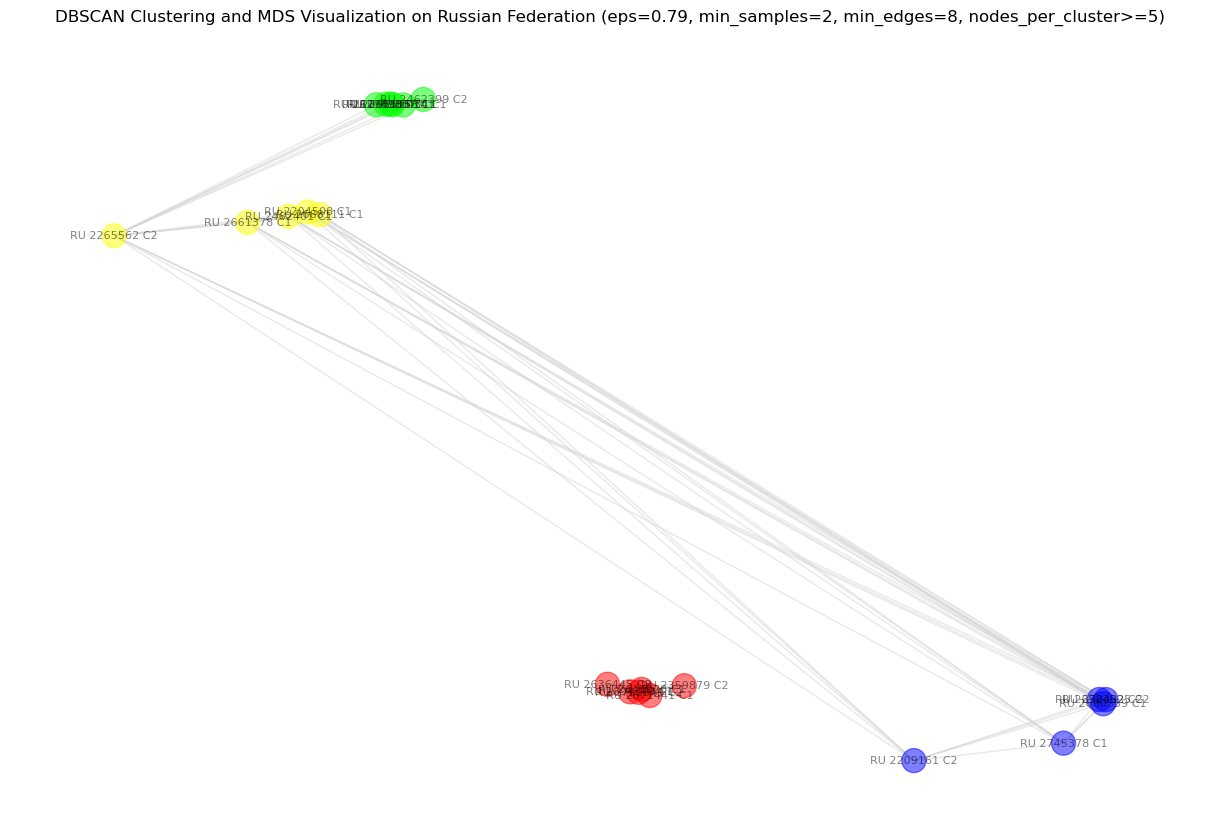

Cluster 15 (Red) Nodes: (6) Keywords: 10, 101, 103, 11, 116, 20, 22, 30, 31, 32, 40, 50, accelerating, approach, area, assembly, associated, astronautics, autonomous, aviation, axis, based, capturing, carried, carrier, cl, cleaning, collection, combination, conducting, control, controlled, controller, debris, decomposing, delivery, development, device, disposal, docking, dwg, effect, electromagnet, end, engines, equipped, example, facility, field, firing, fixed, flight, foamed, forces, frame, gripping, grips, harpoon, help, high, housing, includes, invention, launch, launching, levers, load, loads, magnet, magnetic, maneuvering, manoeuvring, mass, material, means, mentioned, method, module, object, objects, orbit, orbits, os, permanent, placing, possibility, range, realization, relates, relative, removing, rocket, rotatable, rotation, satellite, sd, selection, serviced, shaft, space, spacecraft, specified, speed, ss, start, structural, substance, suppress, surface, target, tests, time,

In [46]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 1,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 8

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 5  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [47]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 15 Red, Nodes (6)

Shared Keywords
10, 101, 103, 11, 116, 20, 22, 30, 31, 32, 40, 50, accelerating, approach, area, assembly, associated, astronautics, autonomous, aviation, axis, based, capturing, carried, carrier, cl, cleaning, collection, combination, conducting, control, controlled, controller, debris, decomposing, delivery, development, device, disposal, docking, dwg, effect, electromagnet, end, engines, equipped, example, facility, field, firing, fixed, flight, foamed, forces, frame, gripping, grips, harpoon, help, high, housing, includes, invention, launch, launching, levers, load, loads, magnet, magnetic, maneuvering, manoeuvring, mass, material, means, mentioned, method, module, object, objects, orbit, orbits, os, permanent, placing, possibility, range, realization, relates, relative, removing, rocket, rotatable, rotation, satellite, sd, selection, serviced, shaft, space, spacecraft, specified, speed, ss, start, structural, substance, suppress, surface, target, tests, 

# European Union

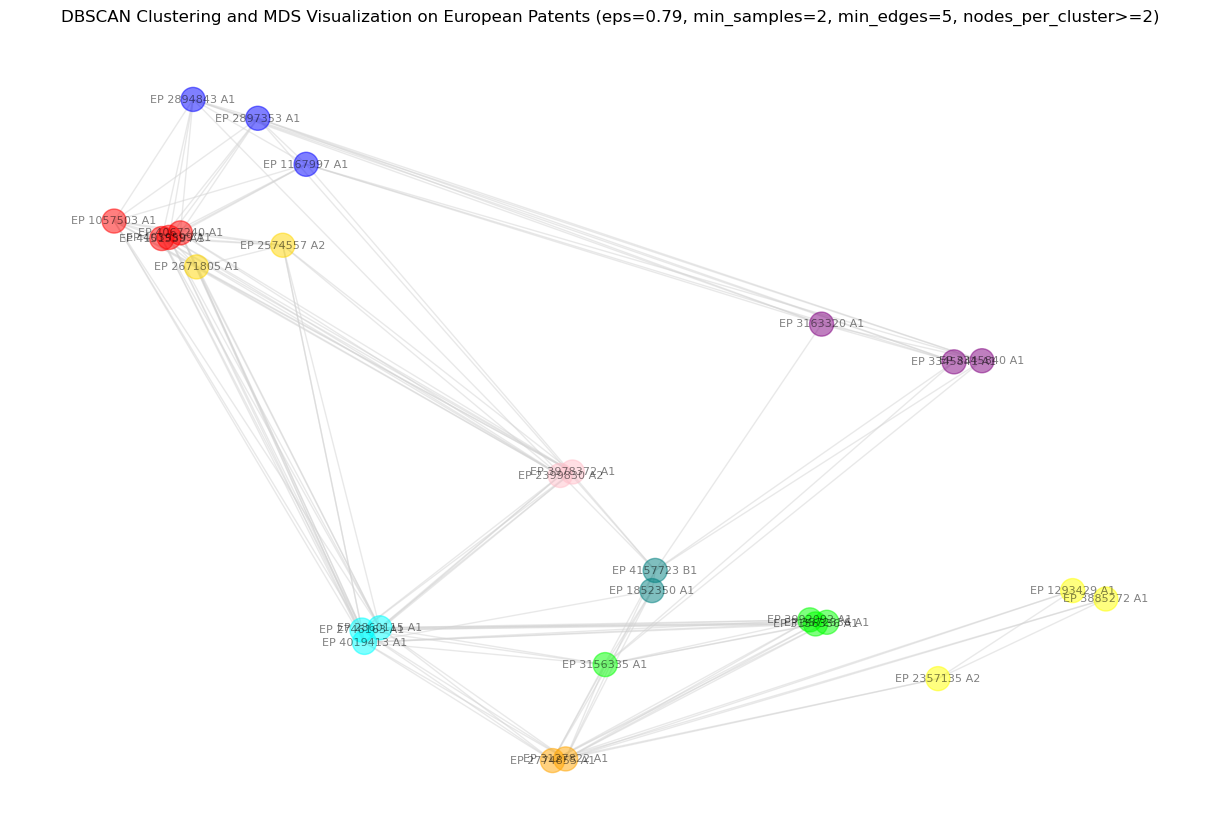

Cluster 32 (Red) Nodes: (4) Keywords: 100, 111, according, action, alert, altitude, analysis, apparatus, area, assist, avoidance, business, category, condition, consist, consists, constellation, danger, debris, device, devices, earth, embodiment, event, flies, forecast, game, hazard, id, includes, information, intrusion, located, management, mega, members, method, mobile, nominal, object, objects, operation, operator, orbit, orbital, outer, pass, passage, performance, planes, playing, plurality, predicted, public, recorder, registration, removal, rocket, said, satellite, security, set, share, space, spacecraft, spatial, surface, technical, terminal, traffic, unit, used, value, warning
Display Keys in Cluster 32: EP 4067240 A1, EP 4151539 A1, EP 4039599 A1, EP 1057503 A1
Cluster 24 (Gold) Nodes: (2) Keywords: 05, 10, 17, 2000, 2008, 2011, 30, 400, 410, aads, archive, artificial, atmosphere, capturing, com, combustible, connecting, coupling, creates, creating, debris, device, fiber, gras

In [48]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 1,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 5

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 2  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [49]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 32 Red, Nodes (4)

Shared Keywords
100, 111, according, action, alert, altitude, analysis, apparatus, area, assist, avoidance, business, category, condition, consist, consists, constellation, danger, debris, device, devices, earth, embodiment, event, flies, forecast, game, hazard, id, includes, information, intrusion, located, management, mega, members, method, mobile, nominal, object, objects, operation, operator, orbit, orbital, outer, pass, passage, performance, planes, playing, plurality, predicted, public, recorder, registration, removal, rocket, said, satellite, security, set, share, space, spacecraft, spatial, surface, technical, terminal, traffic, unit, used, value, warning

Display Keys /w description
EP 4067240 A1 - To achieve an objective to enable a plurality of management business operators managing space objects flying in space, to share and carry out danger analysis efficiently. In a space traffic management system (500), a plurality of space traffic management d

# United Kingdom

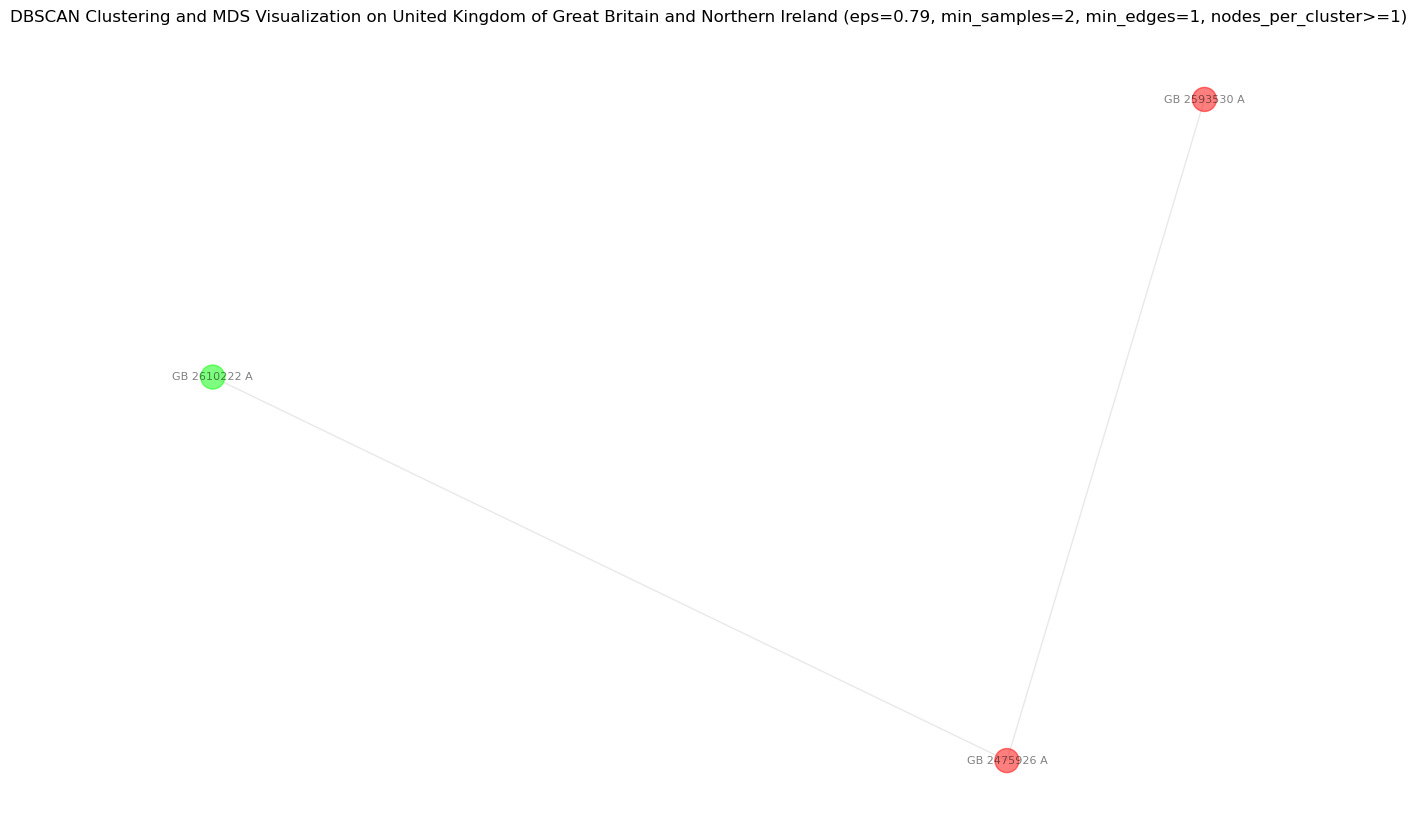

Cluster 13 (Red) Nodes: (2) Keywords: apparatus, body, capture, comprises, debris, deployed, disclosed, driving, em, fig, impact, impeding, incident, include, includes, layer, panels, plurality, position, provide, shield, shielding, spacecraft, stowed, structure, surface, unit
Display Keys in Cluster 13: GB 2593530 A, GB 2475926 A
Cluster 5 (Lime) Nodes: (1) Keywords: 
Display Keys in Cluster 5: GB 2610222 A


In [50]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 0,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 1,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 1

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 1  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [51]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 13 Red, Nodes (2)

Shared Keywords
apparatus, body, capture, comprises, debris, deployed, disclosed, driving, em, fig, impact, impeding, incident, include, includes, layer, panels, plurality, position, provide, shield, shielding, spacecraft, stowed, structure, surface, unit

Display Keys /w description
GB 2593530 A - An impact shield structure for use on a lower earth orbit spacecraft comprises a capture layer 100 to absorb debris incident thereon. The capture layer is disposed on the surface of a spacecraft (or other platform) 101 and includes an exposed surface 103, upon which debris may be incident, and a surface 105 that is adhered to the spacecraft. The capture layer may comprise graphene foam. The shielding structure may further include ceramic powder to provide rigidity and may be impregnated with metallic dust to provide EM shielding. The shielding structure may include a further layer (201, fig 2) providing EM shielding. The capture layer may be sandwiched between two 

# Germany

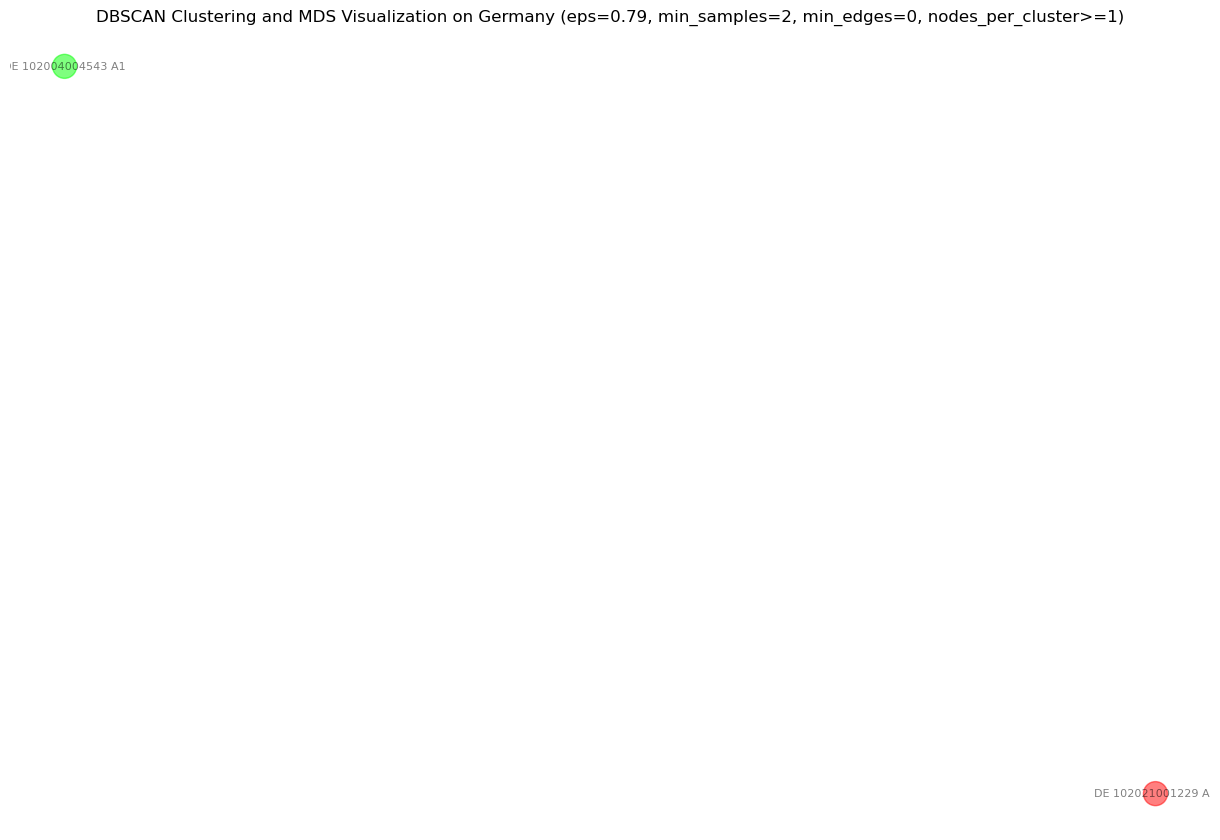

Cluster 13 (Red) Nodes: (1) Keywords: 
Display Keys in Cluster 13: DE 102021001229 A1
Cluster 63 (Lime) Nodes: (1) Keywords: 
Display Keys in Cluster 63: DE 102004004543 A1


In [52]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU acceleration
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load the Excel file and relevant sheets
file_path = 'Debris Data Full.xlsx'
debris_df = pd.read_excel(file_path, sheet_name='Debris')
distance_matrix_df = pd.read_excel(file_path, sheet_name='Patent Debris Distance Matrix')

# Create a "Description" field by combining the "Abstract", "Title", and "NPL Citations"
debris_df['Description'] = debris_df[['Abstract', 'Title', 'NPL Citations']].fillna('').agg(' '.join, axis=1)

# Load the pre-saved reduced distance matrix directly from an Excel sheet
reduced_data_df = pd.read_excel(file_path, sheet_name='Reduced Matrix')
reduced_data = reduced_data_df.values  # Convert DataFrame to NumPy array

# Convert reduced_data to CuPy array for GPU acceleration
reduced_data_gpu = cp.array(reduced_data)

# If the reduced matrix is not precomputed as distances, compute pairwise Euclidean distances using CuPy
distance_matrix_gpu = cp.linalg.norm(reduced_data_gpu[:, None] - reduced_data_gpu[None, :], axis=2)

# Extract the Display Keys from the original distance matrix
display_keys = distance_matrix_df.iloc[:, 0].values

# Specify your parameters for DBSCAN
eps = average_eps  # Example epsilon value
min_samples = average_min_samples  # Example minimum samples value

# Parameter to include or exclude noise points in the visualization
include_noise = False  # Set this to True to include noise points, False to exclude them

# Convert the distance matrix back to NumPy before running DBSCAN (DBSCAN does not natively support CuPy)
distance_matrix = cp.asnumpy(distance_matrix_gpu)

# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(distance_matrix)

# Reduce dimensions using MDS for visualization (MDS needs to be run on the CPU)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
reduced_coords = mds.fit_transform(distance_matrix)

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with positions and clusters, conditionally including noise points
for i, (x, y) in enumerate(reduced_coords):
    cluster_label = clusters[i]
    if cluster_label != -1 or include_noise:  # Include noise if the parameter is set to True
        G.add_node(display_keys[i], pos=(x, y), cluster=cluster_label if cluster_label != -1 else 'noise')

# Create edges based on shared IPCR codes (considering all 30 IPCR Classes)
for i, display_key_1 in enumerate(display_keys):
    for j, display_key_2 in enumerate(display_keys):
        if i >= j:  # Avoid double-counting and self-loops
            continue
        
        ipcr_codes_1 = [debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_1, f'IPCR Class {k}'].values[0])]
        
        ipcr_codes_2 = [debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0] 
                        for k in range(1, 31) if pd.notna(debris_df.loc[debris_df['Display Key'] == display_key_2, f'IPCR Class {k}'].values[0])]
        
        if set(ipcr_codes_1).intersection(ipcr_codes_2):
            G.add_edge(display_key_1, display_key_2)

# Define a parameter for filtering nodes by country
country_filter = {
    '#N/A': 0,
    'Argentina': 0,
    'Australia': 0,
    'Austria': 0,
    'Belgium': 0,
    'Brazil': 0,
    'Bulgaria': 0,
    'Canada': 0,
    'Chile': 0,
    'China': 0,
    'Colombia': 0,
    'Costa Rica': 0,
    'Croatia': 0,
    'Cyprus': 0,
    'Czechia': 0,
    'Denmark': 0,
    'Ecuador': 0,
    'Egypt': 0,
    'European Patents': 0,
    'Finland': 0,
    'France': 0,
    'Georgia': 0,
    'Germany': 1,
    'Greece': 0,
    'Hong Kong': 0,
    'Hungary': 0,
    'India': 0,
    'Ireland': 0,
    'Israel': 0,
    'Italy': 0,
    'Japan': 0,
    'Jordan': 0,
    'Korea (the Republic of)': 0,
    'Latvia': 0,
    'Lithuania': 0,
    'Luxembourg': 0,
    'Malaysia': 0,
    'Mexico': 0,
    'Moldova (the Republic of)': 0,
    'Morocco': 0,
    'Netherlands': 0,
    'New Zealand': 0,
    'Norway': 0,
    'Peru': 0,
    'Philippines': 0,
    'Poland': 0,
    'Portugal': 0,
    'Romania': 0,
    'Russian Federation': 0,
    'Saudi Arabia': 0,
    'Serbia': 0,
    'Singapore': 0,
    'Slovakia': 0,
    'Slovenia': 0,
    'South Africa': 0,
    'Spain': 0,
    'Sweden': 0,
    'Switzerland': 0,
    'Taiwan (Province of China)': 0,
    'Tunisia': 0,
    'Turkey': 0,
    'Ukraine': 0,
    'United Kingdom of Great Britain and Northern Ireland': 0,
    'United States of America': 0,
    'World Intellectual Property Organisation': 0,
    'Zambia': 0
}

# Extract the names of the countries that are selected (i.e., where filter value is 1)
selected_countries = [country for country, value in country_filter.items() if value == 1]

# If all countries are selected, set the title part accordingly
if len(selected_countries) == len(country_filter):
    country_title_part = "All Countries"
else:
    country_title_part = ", ".join(selected_countries)

# Apply the country filter
filtered_nodes = []
for node in G.nodes:
    matching_row = debris_df[debris_df['Display Key'] == node]
    if not matching_row.empty:
        country = matching_row['Country Name'].values[0]
        if country_filter.get(country, 0) == 1:
            filtered_nodes.append(node)

filtered_nodes = list(set(filtered_nodes))  # Remove duplicates
filtered_graph = G.subgraph(filtered_nodes)

# Calculate the degree of each node in the filtered graph
node_degrees = dict(filtered_graph.degree())

# Set the degree threshold (min num of edges needed to be visualized)
degree_threshold = 0

# Further filter nodes based on the degree threshold
final_filtered_nodes = [node for node, degree in node_degrees.items() if degree >= degree_threshold]
final_filtered_graph = filtered_graph.subgraph(final_filtered_nodes)

### Apply the final cluster size filter ###
cluster_sizes = nx.get_node_attributes(final_filtered_graph, 'cluster')
cluster_counts = pd.Series(cluster_sizes.values()).value_counts()

# Filter out clusters with fewer than the threshold number of nodes
threshold = 1  # Example threshold
clusters_to_keep = [cluster for cluster, count in cluster_counts.items() if count >= threshold]

# Filter nodes that belong to clusters with at least the threshold number of nodes
final_filtered_nodes = [
    node for node in final_filtered_graph.nodes()
    if 'cluster' in final_filtered_graph.nodes[node]
    and (
        final_filtered_graph.nodes[node]['cluster'] in clusters_to_keep
        or (include_noise and final_filtered_graph.nodes[node]['cluster'] == 'noise')
    )
]

# If noise should not be included, filter it out explicitly
if not include_noise:
    final_filtered_nodes = [
        node for node in final_filtered_nodes
        if final_filtered_graph.nodes[node]['cluster'] != 'noise'
    ]

final_filtered_graph = final_filtered_graph.subgraph(final_filtered_nodes)

# Get positions for nodes again after final filtering
pos = nx.get_node_attributes(final_filtered_graph, 'pos')

# Define a color map for clusters, including a special color for noise if included
vos_colors = {
    '#FF0000': 'Red',
    '#00FF00': 'Green',
    '#0000FF': 'Blue',
    '#FFFF00': 'Yellow',
    '#800080': 'Purple',
    '#00FFFF': 'Cyan',
    '#FFA500': 'Orange',
    '#FFC0CB': 'Pink',
    '#00FF00': 'Lime',
    '#008080': 'Teal',
    '#FFD700': 'Gold',
    '#ADFF2F': 'Green Yellow',
    '#FF69B4': 'Hot Pink',
    '#CD5C5C': 'Indian Red',
    '#4B0082': 'Indigo',
    'gray': 'Noise'  # Special color for noise points
}

# Create a list of color keys
color_keys = list(vos_colors.keys())

# Create a mapping from cluster label to VOSviewer color based on their order in the clusters_to_keep list
cluster_to_color = {cluster: color_keys[i % len(color_keys)] for i, cluster in enumerate(clusters_to_keep)}
if include_noise:
    cluster_to_color['noise'] = 'gray'  # Assign gray color for noise points

# Assign colors based on the cluster-to-color mapping
colors = [cluster_to_color[final_filtered_graph.nodes[node]['cluster']] for node in final_filtered_graph.nodes()]

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(final_filtered_graph, pos, node_color=colors, with_labels=True, labels={node: node for node in final_filtered_graph.nodes()},
        font_size=8, alpha=0.5, node_size=300, edge_color='lightgray', width=1.0)
plt.title(f'DBSCAN Clustering and MDS Visualization on {country_title_part} (eps={eps:.2f}, min_samples={min_samples}, min_edges={degree_threshold}, nodes_per_cluster>={threshold})')
plt.show()

# Initialize dictionaries for storing cluster descriptions and counts
cluster_descriptions = {}
cluster_node_counts = {}

# Group descriptions and count nodes by cluster
for node in final_filtered_graph.nodes():
    cluster = final_filtered_graph.nodes[node]['cluster']

    # Ensure the cluster is initialized in the dictionaries
    if cluster not in cluster_descriptions:
        cluster_descriptions[cluster] = []
        cluster_node_counts[cluster] = 0

    # Append the description and increment the node count for the cluster
    description = debris_df.loc[debris_df['Display Key'] == node, 'Description'].values[0]
    cluster_descriptions[cluster].append(description)
    cluster_node_counts[cluster] += 1  # Increment the node count for the cluster

# Extract keywords from descriptions
for cluster, descriptions in cluster_descriptions.items():
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        keywords = []

    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color is found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    print(f"Cluster {cluster} ({color_name}) Nodes: ({node_count}) Keywords: {', '.join(keywords)}")
    print(f"Display Keys in Cluster {cluster}: {', '.join(display_keys_in_cluster)}")

In [53]:
# Iterate through all clusters to display their information
for cluster, descriptions in cluster_descriptions.items():
    
    # Get shared keywords for the cluster
    if len(descriptions) > 1:  # Ensure there are at least 2 descriptions to compare
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(descriptions)
        word_counts = X.toarray().sum(axis=0)
        shared_keywords = [word for word, count in zip(vectorizer.get_feature_names_out(), word_counts) if count > 1]
    else:
        shared_keywords = []

    # Get the cluster color and other details
    color_hex = cluster_to_color.get(cluster, '#000000')  # Default to black if no color found
    color_name = vos_colors.get(color_hex, 'Unknown')

    node_count = cluster_node_counts[cluster]  # Get the node count for the current cluster

    # Retrieve the display keys for the nodes in this cluster
    display_keys_in_cluster = [node for node in final_filtered_graph.nodes() if final_filtered_graph.nodes[node]['cluster'] == cluster]

    # Print the cluster header
    print(f"Cluster {cluster} {color_name}, Nodes ({node_count})")
    
    # Print shared keywords
    print(f"\nShared Keywords\n{', '.join(shared_keywords) if shared_keywords else 'No shared keywords'}\n")

    # Print Display Keys and Descriptions
    print("Display Keys /w description")
    for display_key in display_keys_in_cluster:
        description = debris_df.loc[debris_df['Display Key'] == display_key, 'Description'].values[0]
        print(f"{display_key} - {description}")  # Print full description
    
    print("\n" + "-"*50 + "\n")


Cluster 13 Red, Nodes (1)

Shared Keywords
No shared keywords

Display Keys /w description
DE 102021001229 A1 - Technisches Problem: Nach dem Stand der Technik kÃ¶nnen fÃ¼r die Beseitigung von Space Debris Objects = WeltraummÃ¼ll-Objekte (SDOs) mehrere Verfahren eingesetzt werden, die folgende Nachteile aufweisen: komplexe Konstruktion der RaumflugkÃ¶rper fÃ¼r die Beseitigung der SDOs; Notwendigkeit einer genauen FÃ¼hrung solcher RaumflugkÃ¶rper auf ihrer Bahn; SelektivitÃ¤t der einigen Verfahren bezÃ¼glich der SDOs z.B. aufgrund deren GrÃ¶ÃŸe oder elektrischer Ladung; niedrige Effizienz der Verfahren.LÃ¶sung des technischen Problems: Das neue Verfahren zur Beseitigung von SDOs basiert auf dem Abbremsen der SDOs durch den Impulsaustausch mit kleinen kristallinen, amorphen und flÃ¼ssigen Partikeln. Die Partikeln formen dabei kompakte Partikelobjekte, die mit einer gewissen Geschwindigkeit auf SDOs zufliegen und mit denen sie dann zusammenprallen, ohne die SDOs zu zerstÃ¶ren. Die Partike